In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Функция для расчета WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [3]:
df = pd.read_csv('для модели v6.csv', parse_dates=['report_date'])

In [ ]:
target_ = 'target_area'

In [4]:
cat = df.copy()
cat.shape
# оставляем с непропущенными таргетом
cat=cat[cat[target_].notnull()]
cat.shape[0]

7100

In [5]:
def split_train_oot(data):
    # Находим самую позднюю дату в данных
    latest_date = data['report_date'].max()

    # Вычисляем дату, которая была три месяца назад от самой поздней даты
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # Отбираем строки, где report_date попадает в последние три месяца
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # Теперь заполним NaN значения в столбце 'split_type' значением 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [6]:
# Функция для расчета всех метрик
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [7]:
def shap_gr(name_model, values):# Инициализация SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # Создаем фигуру с регулируемым местом для шкалы
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # Настройки графика
    ax1.set_title("Важность признаков по SHAP значениям", fontsize=14, pad=20)
    ax1.set_xlabel("Влияние на выход модели (SHAP value)", fontsize=12)
    ax1.set_ylabel("Признаки", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [8]:
cat = split_train_oot(cat)

# Модель

# Тест 1

In [9]:
# cat =  cat.sort_values(by='report_date')# сортировка по дате перед обучением
cat['year'] = cat['report_date'].dt.year
cat['month'] = cat['report_date'].dt.month
cat['quarter'] = cat['report_date'].dt.quarter
cat.drop('report_date', axis=1, inplace=True)

In [10]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date'
] + target_


In [11]:
# Разделяем данные
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# Подготовка признаков
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# Инициализация и обучение модели
model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_base = metrics_df

In [12]:
metrics_df_base

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,34.759269,8201.279834,90.560918,0.112690,0.066575,0.972402,522.109088,508.796277,5961
1,test,230.577459,114544.673654,338.444491,1.587632,0.742579,0.020535,310.508982,463.019817,1139


# Отбор фич

In [13]:
cat = df.copy()
cat.shape
# оставляем с непропущенными таргетом
cat=cat[cat[target_].notnull()]
cat.shape[0]

7100

In [14]:
cat = split_train_oot(cat)

In [15]:
# Подготовка данных
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# Уникальные значения по времени в тренировочной выборке
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# Список для сбора выбранных фич и метрик
features_across_splits = []
metrics_across_splits = []

# Инициализация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Сортируем данные по дате для корректного разбиения
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\n🔹 Сплит {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # Создание Pool объектов
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # Инициализация модели
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # Обучение модели
    model.fit(train_pool, eval_set=val_pool)
    
    # Предсказания и метрики
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # Расчет метрик для train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # Расчет метрик для validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # Отбор фичей
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" Отобрано фичей: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame(metrics_across_splits)

# Форматируем даты 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# Переупорядочиваем столбцы
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# Анализ фичей
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n Итоговые устойчивые фичи (встречались >= 2 раз):")
print("Количество:", len(final_features))



🔹 Сплит 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 213.9495745
bestIteration = 123

Shrink model to first 124 iterations.
Feature #35 eliminated
Feature #102 eliminated
Feature #25 eliminated
Feature #28 eliminated
Feature #855 eliminated
Feature #331 eliminated
Feature #50 eliminated
Feature #752 eliminated
Feature #645 eliminated
Feature #245 eliminated
Feature #788 eliminated
Feature #529 eliminated
Feature #244 eliminated
Feature #8 eliminated
Feature #600 eliminated
Feature #608 eliminated
Feature #1048 eliminated
Feature #661 eliminated
Feature #730 eliminated
Feature #654 eliminated
Feature #1042 eliminated
Feature #513 eliminated
Feature #20 eliminated
Feature #191 eliminated
Feature #585 eliminated
Feature #54 eliminated
Feature #430 eliminated
Feature #34 eliminated
Feature #156 eliminated
Feature #986 eliminated
Feature #782 eliminated
Feature #734 eliminated
Feature #315 eliminated
Feat

In [16]:
metrics_df_select_features

,split,start_date,end_date,n_samples,mean_target,mean_pred,mae,rmse,mape,wape,r2
0,fold_1_train,2022-03-01,2022-09-01,996,588.572450,541.495396,120.730344,235.284215,0.345784,0.205124,0.846972
1,fold_1_val,2022-09-01,2023-03-01,993,469.433515,476.272066,212.045662,317.627626,0.903592,0.451705,0.529644
2,fold_2_train,2022-03-01,2023-03-01,1989,529.092831,501.098459,61.663929,154.578867,0.176672,0.116547,0.918108
3,fold_2_val,2023-03-01,2023-08-01,993,461.282759,447.251508,188.210765,284.029646,0.917607,0.408016,0.640836
4,fold_3_train,2022-03-01,2023-08-01,2982,506.512213,478.215655,72.410705,166.103960,0.228077,0.142959,0.897978
5,fold_3_val,2023-08-01,2023-12-01,993,640.243868,543.421088,232.253933,362.846090,0.762951,0.362759,0.708634
6,fold_4_train,2022-03-01,2023-12-01,3975,539.919895,449.842225,213.423755,382.112413,0.779935,0.395288,0.542447
7,fold_4_val,2023-12-01,2024-03-01,993,448.587966,511.781988,238.223483,355.192988,1.322749,0.531052,0.470090
8,fold_5_train,2022-03-01,2024-03-01,4968,521.664539,492.451589,90.163422,184.382144,0.291253,0.172838,0.888260
9,fold_5_val,2024-03-01,2024-06-01,993,524.333173,401.416120,213.614413,334.595386,0.595311,0.407402,0.572330


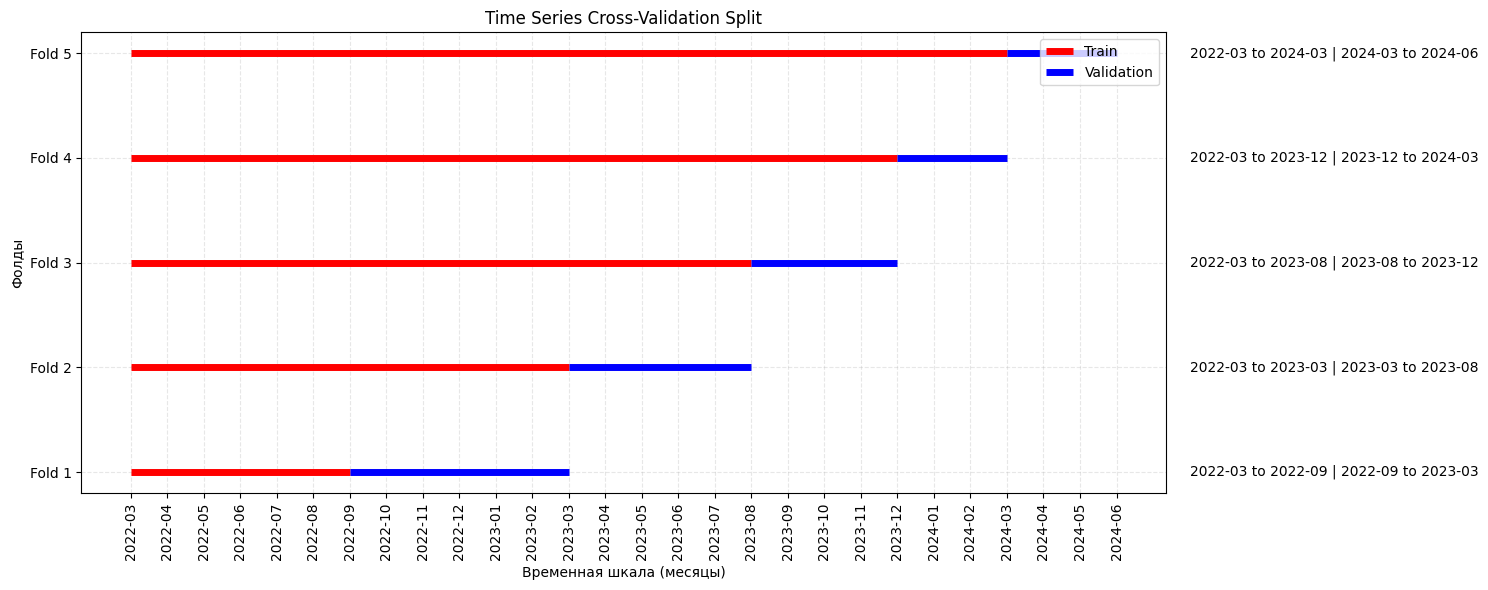

In [21]:
plt.figure(figsize=(15, 6))

# Получаем все уникальные даты
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # Формат YYYY-MM

# Цвета для train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # Находим индексы дат
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # Рисуем линии
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# Настройка графика
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('Временная шкала (месяцы)')
plt.ylabel('Фолды')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# Добавим подписи дат для каждого фолда
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [18]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

,area__g_building__smt_projected_total_area__rooms_2__sum,expon_cost__g_building__pc_cost__day_5__avg__1M,price__g_building__rooms_0__sum__1M,reservations__g_building__smt_projected_total_area__long_reservation__sum__6M,balance__g_building__rooms_3plus__sum,area__g_building__smt_projected_total_area__reservation_end_next_month__sum,area__g_building__smt_projected_total_area__rooms_3plus__count,mortgages__g_building__approved_amount__max__1M,cost_net__g_building__sale_cost__rooms_2__sum__1M,reservations__g_building__smt_projected_total_area__rooms_1__sum__1M,...,sales__g_building__sale_cost__rooms_1__count__3M,reservations__g_building__smt_projected_total_area__rooms_3plus__sum__3M,rosstat_m__g_rd__debt_housing_loans_resident__avg__1_12M,expon_cost__g_building__pc_cost_diff__min__1M,area__g_building__smt_projected_total_area__str_r__count,expon_cost__g_building__pc_cost_diff__rooms_3plus__avg__1M,expon_cost__g_building__pc_cost_diff_rel__avg__6M,expon_cost__g_building__pc_cost__max__3M,expon_cost__g_building__pc_cost__avg__3M,area__g_building__smt_projected_total_area__rooms_3plus_str_r__count
11,14610.101,189968.00,667908500.0,NaN,16826.0,NaN,268.0,NaN,NaN,0.0,...,0.0,NaN,12681546.0,NaN,0.0,NaN,0.007264,189968.0,189862.61,0.0
12,14610.101,189968.00,689522750.0,NaN,16648.4,168.1,268.0,219178.1,142752.908307,193.9,...,5.0,177.6,12846716.0,5265.0,577.0,NaN,0.017490,207803.0,174209.28,NaN
13,14610.101,174418.05,627455360.0,149.8,16132.5,100.2,268.0,330672.5,144661.367634,NaN,...,20.0,744.3,13005159.0,-10390.0,480.0,-8275.347,-0.049824,207803.0,170714.69,NaN


In [19]:
# Разделение столбцов
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые столбцы:", numeric_cols)
print("Категориальные столбцы:", categorical_cols)

Числовые столбцы: ['area__g_building__smt_projected_total_area__rooms_2__sum', 'expon_cost__g_building__pc_cost__day_5__avg__1M', 'price__g_building__rooms_0__sum__1M', 'reservations__g_building__smt_projected_total_area__long_reservation__sum__6M', 'balance__g_building__rooms_3plus__sum', 'area__g_building__smt_projected_total_area__reservation_end_next_month__sum', 'area__g_building__smt_projected_total_area__rooms_3plus__count', 'mortgages__g_building__approved_amount__max__1M', 'cost_net__g_building__sale_cost__rooms_2__sum__1M', 'reservations__g_building__smt_projected_total_area__rooms_1__sum__1M', 'mortgages__g_building__smt_loan_period__avg__1M', 'area__g_building__smt_projected_total_area__str_r__sum', 'mortgages__g_building__approved_amount__min__6M', 'area__g_building__smt_projected_total_area__rooms_2_reserved__count', 'area__g_building__smt_projected_total_area__reserved__sum', 'mortgages__g_building__loan_amount__avg__1M', 'mortgages__g_building__approved_amount__min__1M'

In [20]:

# Создаем словарь для YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols
}

# Записываем в YAML-файл
with open('features_v5.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [22]:
# загрузим фичи
with open('features_v5.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. Извлечение списков столбцов
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [23]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

,area__g_building__smt_projected_total_area__rooms_2__sum,expon_cost__g_building__pc_cost__day_5__avg__1M,price__g_building__rooms_0__sum__1M,reservations__g_building__smt_projected_total_area__long_reservation__sum__6M,balance__g_building__rooms_3plus__sum,area__g_building__smt_projected_total_area__reservation_end_next_month__sum,area__g_building__smt_projected_total_area__rooms_3plus__count,mortgages__g_building__approved_amount__max__1M,cost_net__g_building__sale_cost__rooms_2__sum__1M,reservations__g_building__smt_projected_total_area__rooms_1__sum__1M,...,sales__g_building__sale_cost__rooms_1__count__3M,reservations__g_building__smt_projected_total_area__rooms_3plus__sum__3M,rosstat_m__g_rd__debt_housing_loans_resident__avg__1_12M,expon_cost__g_building__pc_cost_diff__min__1M,area__g_building__smt_projected_total_area__str_r__count,expon_cost__g_building__pc_cost_diff__rooms_3plus__avg__1M,expon_cost__g_building__pc_cost_diff_rel__avg__6M,expon_cost__g_building__pc_cost__max__3M,expon_cost__g_building__pc_cost__avg__3M,area__g_building__smt_projected_total_area__rooms_3plus_str_r__count
0,14610.101,189968.00,667908500.0,NaN,16826.0,NaN,268.0,NaN,NaN,0.00000,...,0.0,NaN,12681546.0,NaN,0.0,NaN,0.007264,189968.0,189862.61,0.0
1,14610.101,189968.00,689522750.0,NaN,16648.4,168.1,268.0,219178.1,142752.908307,193.90000,...,5.0,177.6,12846716.0,5265.00,577.0,NaN,0.017490,207803.0,174209.28,NaN
2,14610.101,174418.05,627455360.0,149.8,16132.5,100.2,268.0,330672.5,144661.367634,NaN,...,20.0,744.3,13005159.0,-10390.00,480.0,-8275.34700,-0.049824,207803.0,170714.69,NaN
3,14610.101,166069.97,543015230.0,400.8,15198.6,180.7,268.0,NaN,146638.377599,267.00000,...,26.0,1756.9,13160337.0,-0.03,393.0,454.93134,-0.009326,207803.0,169195.05,156.0
4,14610.101,168623.40,508770400.0,502.5,14677.3,144.8,268.0,547945.2,149379.666096,230.20001,...,27.0,2340.4,13341992.0,1694.00,357.0,3335.53340,-0.007924,207803.0,168666.53,147.0


In [24]:
filtered_df = split_train_oot(filtered_df)

# Модель 2 на выбранных фичах

In [25]:
# Разделим данные на тренировочные и тестовые
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# Выберите признаки (features) и целевую переменную (target)
# Допустим, у вас есть столбец 'target', который нужно предсказать
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid',
                         target_])  
y_test = test_data[target_]

# Инициализируем модель 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=8,         
                    learning_rate=0.1,  # Уменьшаем learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=3,   
                    random_strength=1,
                    early_stopping_rounds=100,  # Ранняя остановка
                    verbose=200,
                    grow_policy='Lossguide'  # Альтернативная стратегия роста
                )
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)

# Делаем предсказания 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_with_select_features = metrics_df

0:	learn: 344.9450129	total: 7.65ms	remaining: 15.3s
200:	learn: 117.8711998	total: 1.44s	remaining: 12.9s
400:	learn: 95.5402517	total: 2.8s	remaining: 11.2s
600:	learn: 86.3204512	total: 4.2s	remaining: 9.78s
800:	learn: 79.9699202	total: 5.58s	remaining: 8.35s
1000:	learn: 75.4029096	total: 6.98s	remaining: 6.96s
1200:	learn: 71.9420603	total: 8.39s	remaining: 5.58s
1400:	learn: 68.8098697	total: 9.8s	remaining: 4.19s
1600:	learn: 66.6446148	total: 11.2s	remaining: 2.79s
1800:	learn: 64.6109151	total: 12.6s	remaining: 1.39s
1999:	learn: 62.7138434	total: 14s	remaining: 0us


In [26]:
metrics_df_with_select_features

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,62.713844,19189.622980,138.526615,0.221215,0.120116,0.935426,522.109088,501.790822,5961
1,test,246.918558,124545.101319,352.909480,1.658229,0.795206,-0.064978,310.508982,496.470918,1139


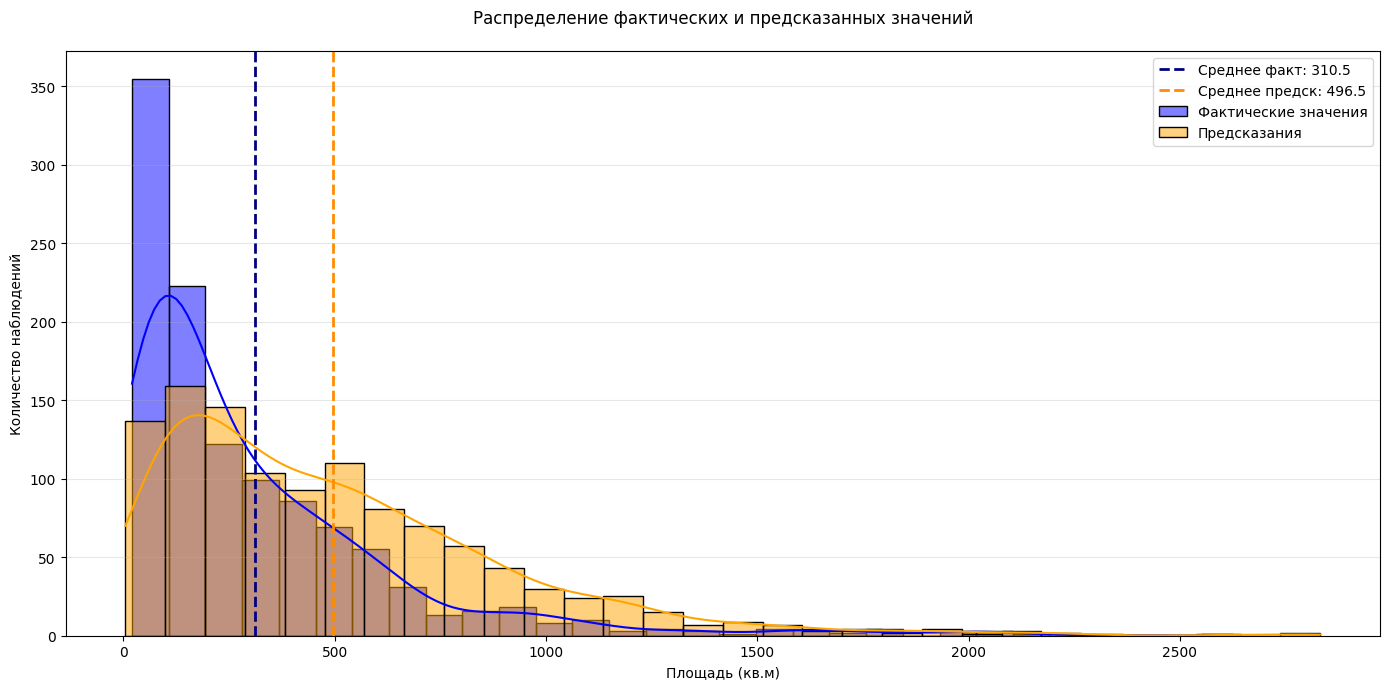

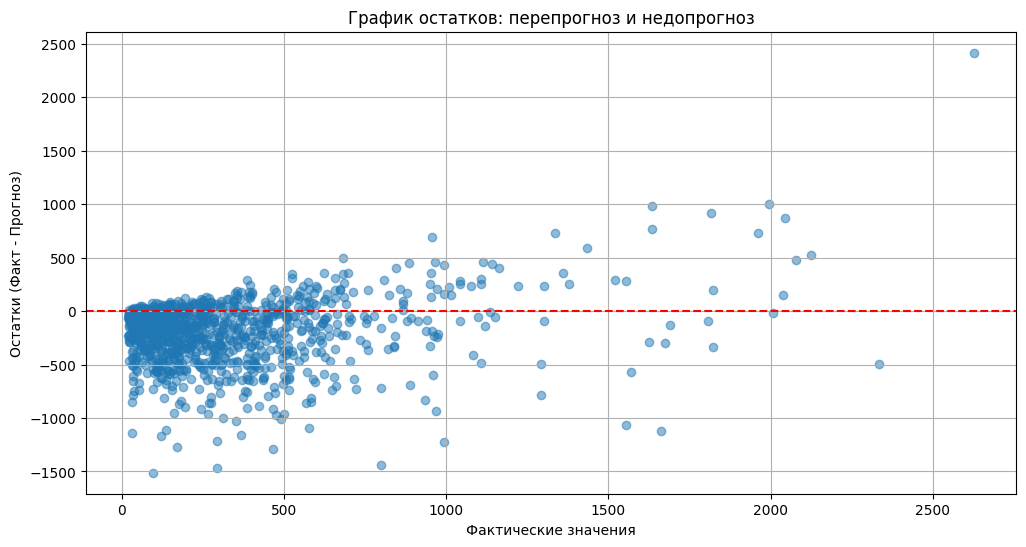

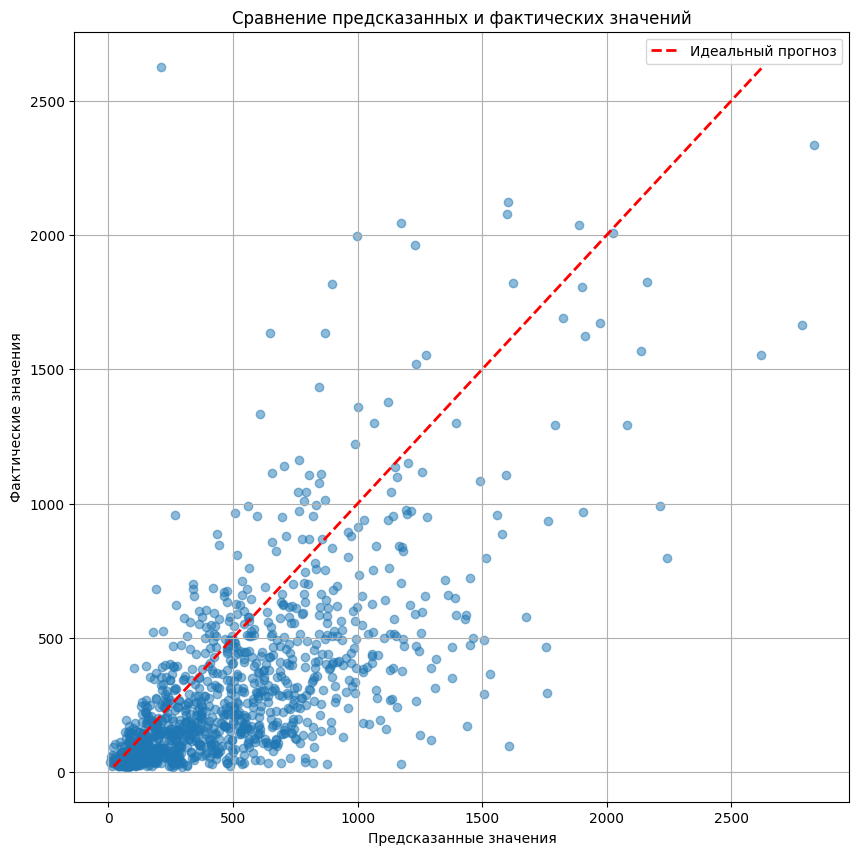

In [ ]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()

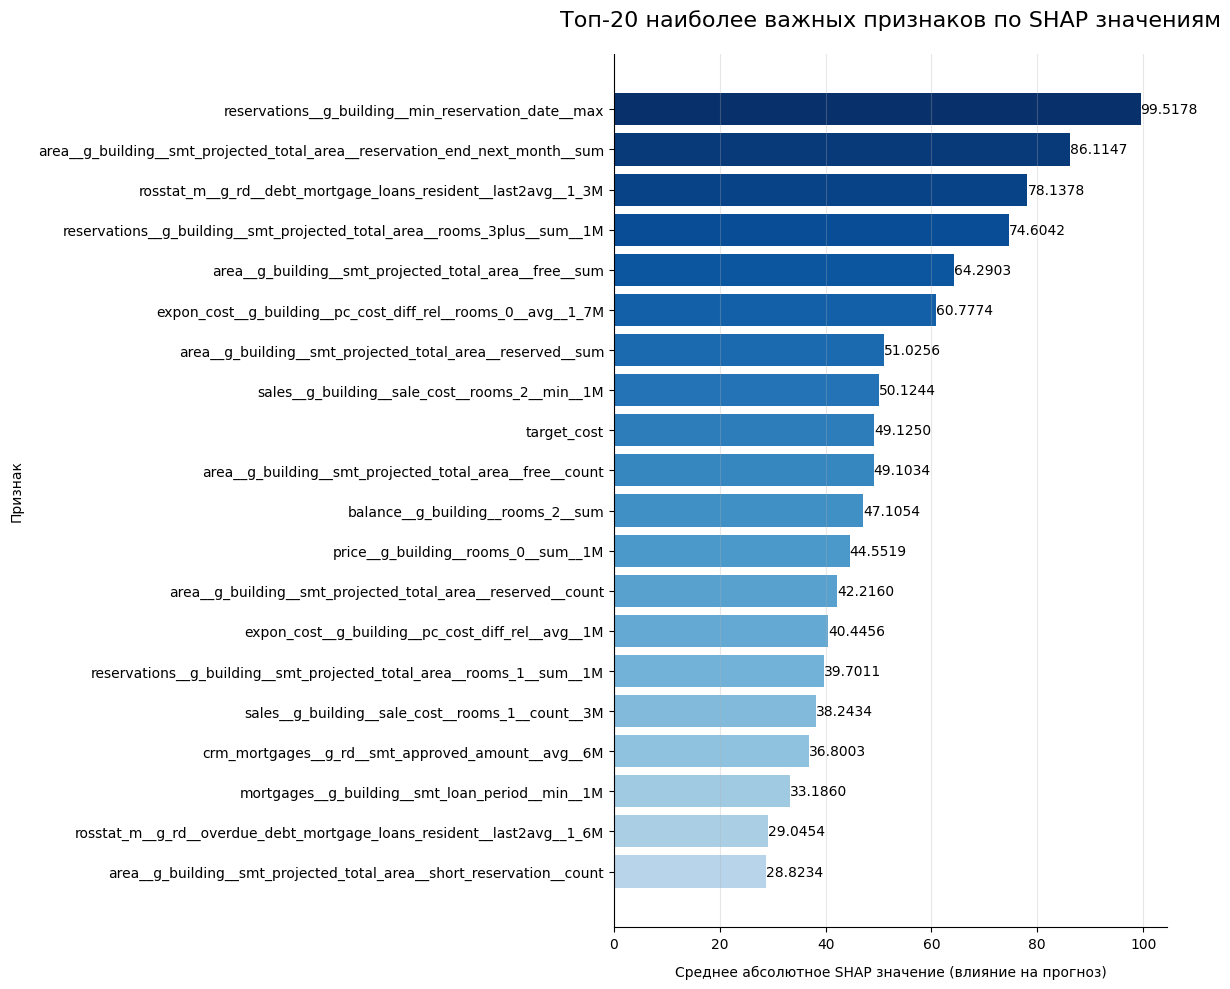

In [29]:
# Инициализация и расчет SHAP значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Создаем DataFrame с важностью фич
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# Стилизация графика
plt.figure(figsize=(12, 10))

# Горизонтальный bar plot с цветовой градацией
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# Добавляем значения на график
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# Настройки внешнего вида
plt.title('Топ-20 наиболее важных признаков по SHAP значениям', pad=20, fontsize=16)
plt.xlabel('Среднее абсолютное SHAP значение (влияние на прогноз)', labelpad=10)
plt.ylabel('Признак', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


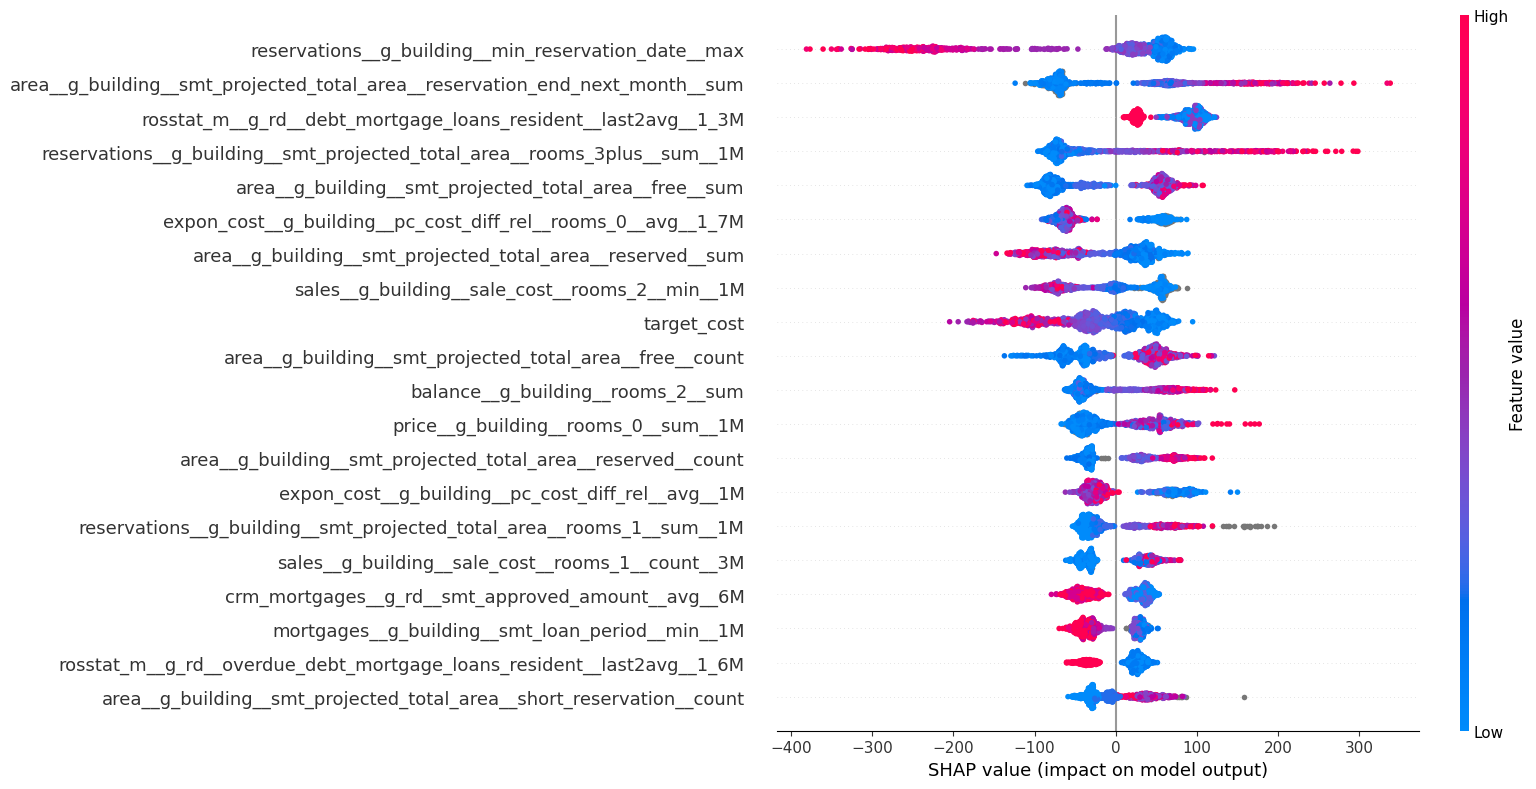

In [28]:
shap_gr(model, X_test)

# OPTUNA

In [30]:
# Разделяем данные
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', target_])
y_test = test_data[target_]

# Делим часть train на train/valid для Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# Для CatBoost нужно указывать cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# Улучшенная оптимизация через Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # Добавляем параметры в зависимости от типа бутстрапа
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Улучшенный запуск Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=30)  

print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# Удаляем параметры, которые не нужны в финальной модели
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# Делаем предсказания 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_optuna = metrics_df

[I 2025-05-15 11:33:50,123] A new study created in memory with name: no-name-3ded1694-f074-4319-a937-656f87b26016
[I 2025-05-15 11:33:53,206] Trial 0 finished with value: 185.78065267468918 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 185.78065267468918.
[I 2025-05-15 11:33:55,033] Trial 1 finished with value: 199.9046404110498 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 185.78065267468918.
[I 2025-05-15 11:33:57,524] Trial 2 

Лучшие параметры:
iterations: 1636
depth: 7
learning_rate: 0.03699191530070529
l2_leaf_reg: 0.005179846118033752
random_strength: 2.4204873704427543
border_count: 53
min_data_in_leaf: 59
grow_policy: Depthwise
bootstrap_type: MVS
0:	learn: 355.3327696	total: 4.18ms	remaining: 4.17s
100:	learn: 185.4973885	total: 392ms	remaining: 3.49s
200:	learn: 164.2055738	total: 723ms	remaining: 2.88s
300:	learn: 145.8824812	total: 1.03s	remaining: 2.39s
400:	learn: 131.5106891	total: 1.32s	remaining: 1.97s
500:	learn: 121.8534104	total: 1.61s	remaining: 1.6s
600:	learn: 115.0015597	total: 1.9s	remaining: 1.26s
700:	learn: 109.4162310	total: 2.18s	remaining: 931ms
800:	learn: 105.1506101	total: 2.47s	remaining: 614ms
900:	learn: 101.7428303	total: 2.76s	remaining: 303ms
999:	learn: 99.0545935	total: 3.04s	remaining: 0us


In [31]:
metrics_df_optuna

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,99.054595,36166.529336,190.174997,0.334424,0.189720,0.878299,522.109088,494.161024,5961
1,test,222.250814,105977.782363,325.542290,1.509482,0.715763,0.093790,310.508982,468.664377,1139


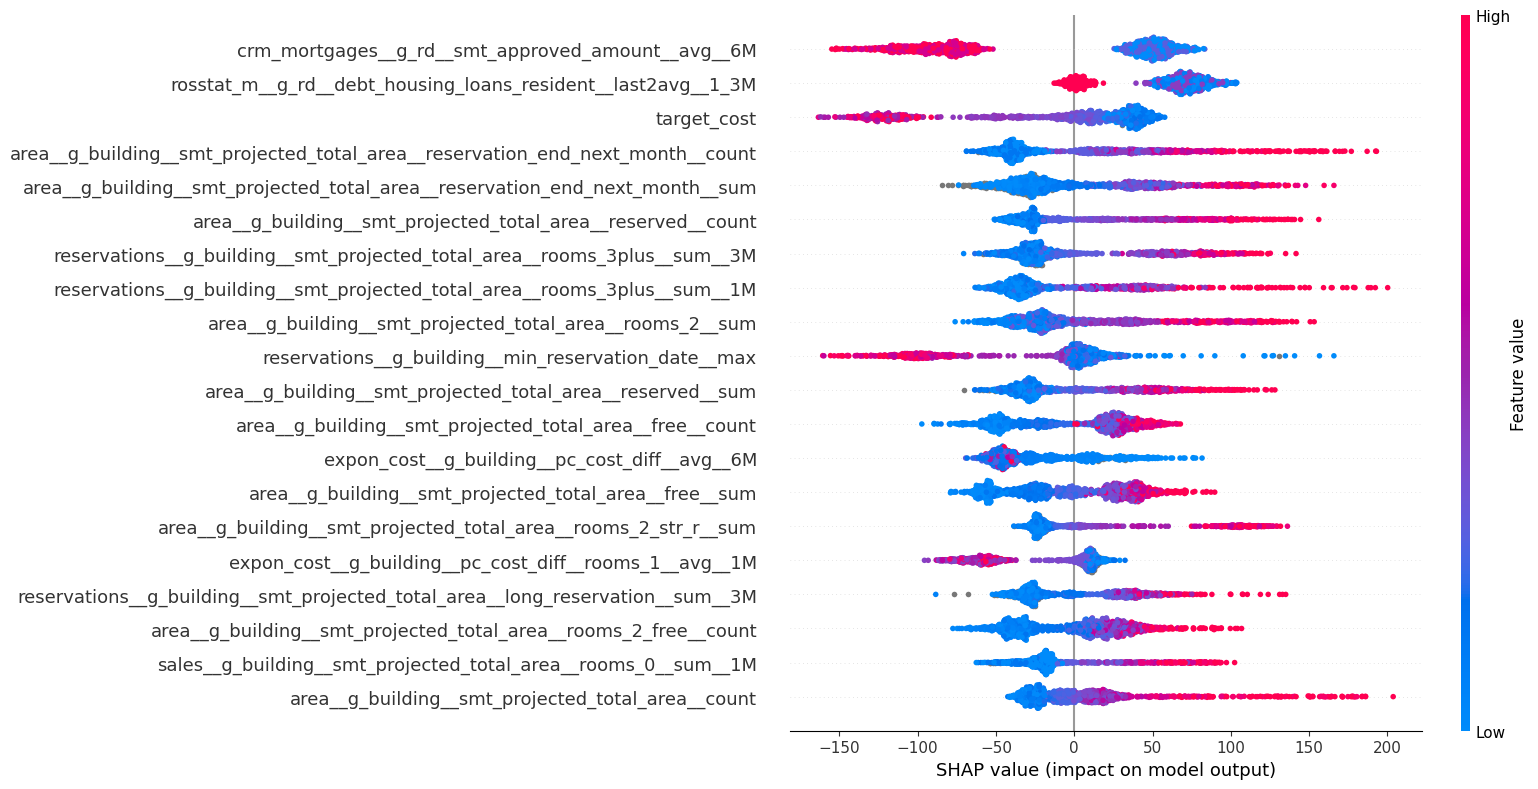

In [32]:
shap_gr(final_model, X_test)

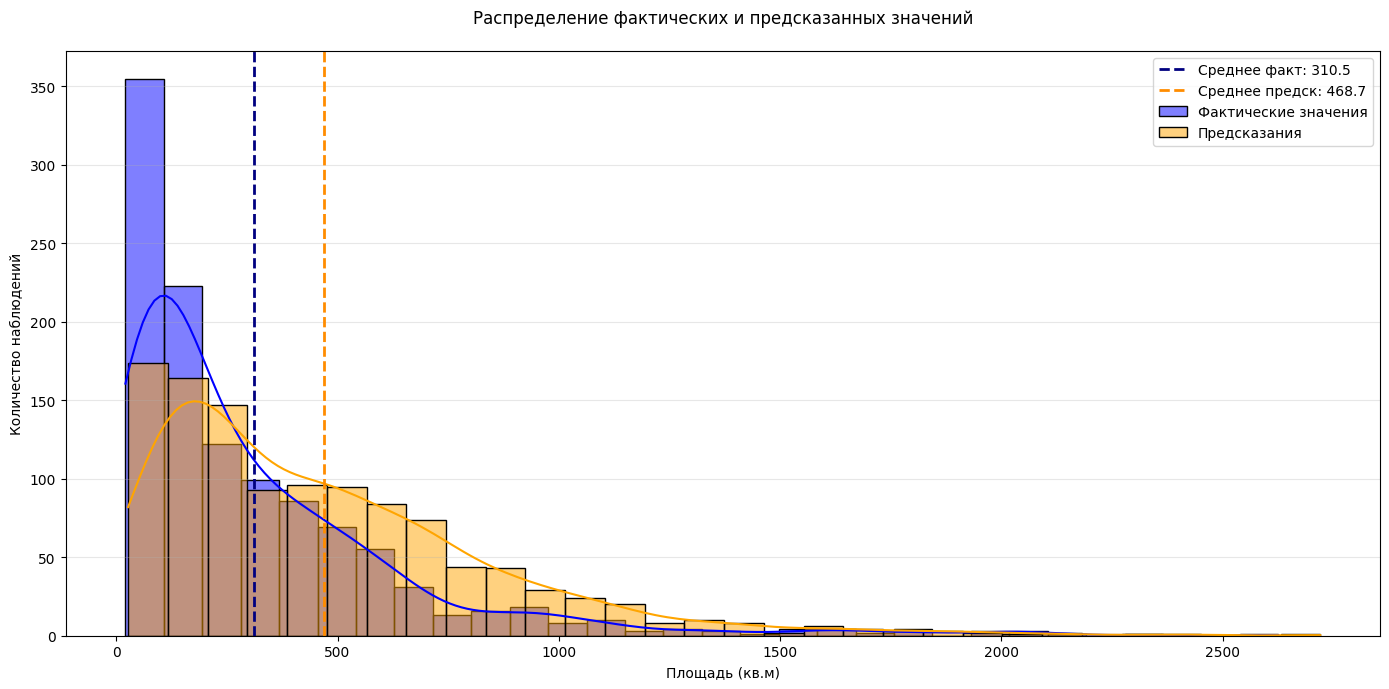

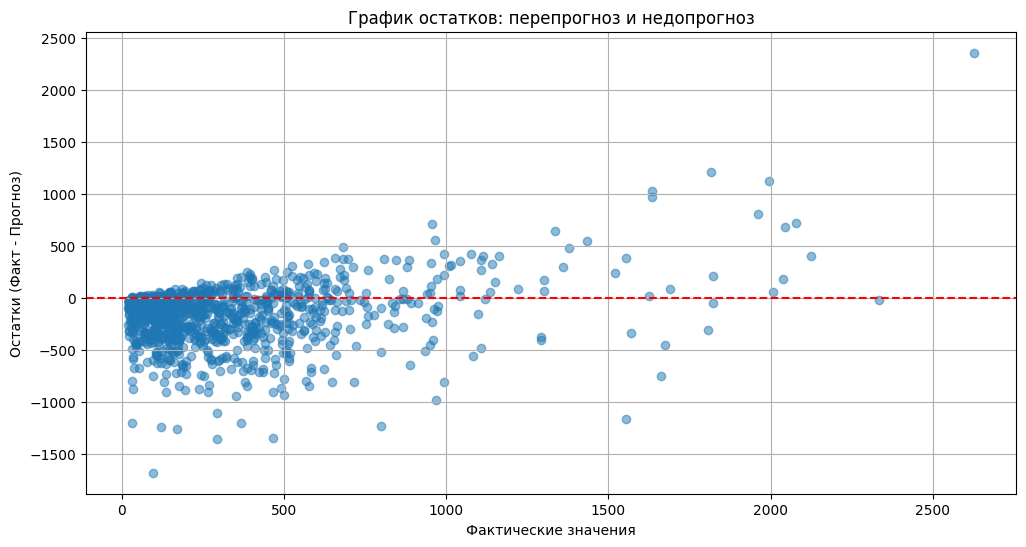

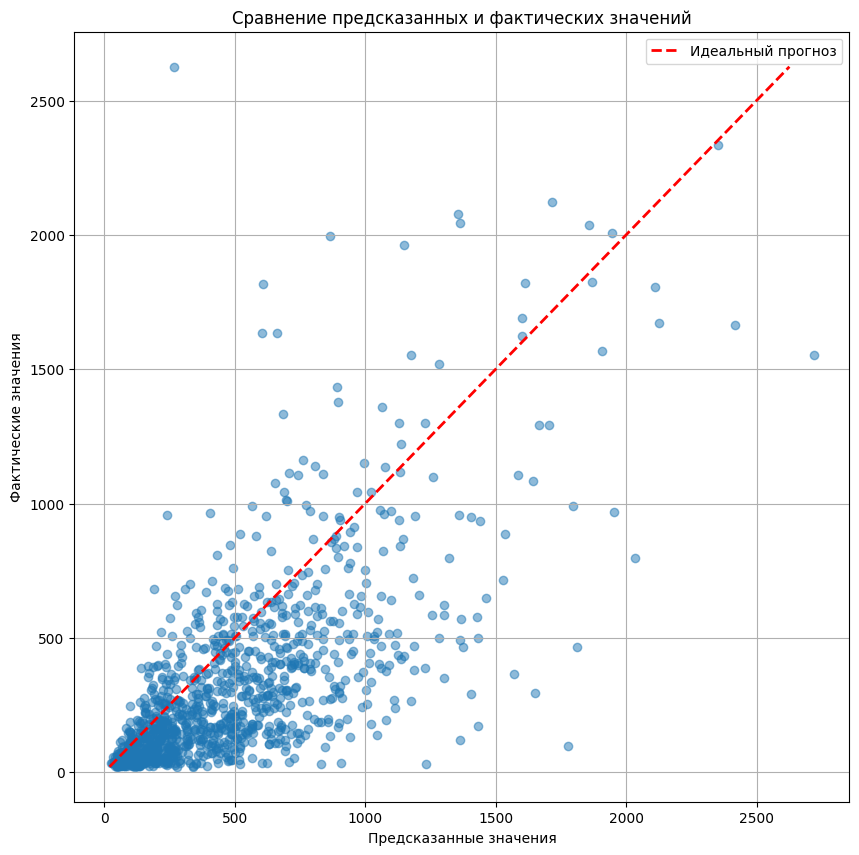

In [36]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()


In [37]:
metrics_df_base.insert(0, 'stage', 'Базовая модель')
metrics_df_with_select_features.insert(0, 'stage', 'Модель с отбором признаков')
metrics_df_optuna.insert(0, 'stage', 'Оптимизированная модель (Optuna)')

In [39]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

,stage,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,Базовая модель,train,34.759269,8201.279834,90.560918,0.112690,0.066575,0.972402,522.109088,508.796277,5961
1,Базовая модель,test,230.577459,114544.673654,338.444491,1.587632,0.742579,0.020535,310.508982,463.019817,1139
2,Модель с отбором признаков,train,62.713844,19189.622980,138.526615,0.221215,0.120116,0.935426,522.109088,501.790822,5961
3,Модель с отбором признаков,test,246.918558,124545.101319,352.909480,1.658229,0.795206,-0.064978,310.508982,496.470918,1139
4,Оптимизированная модель (Optuna),train,99.054595,36166.529336,190.174997,0.334424,0.189720,0.878299,522.109088,494.161024,5961
5,Оптимизированная модель (Optuna),test,222.250814,105977.782363,325.542290,1.509482,0.715763,0.093790,310.508982,468.664377,1139


In [ ]:
X_test_modified = X_test.copy()

all_metrics = []

# Цикл по alpha 
for alpha in np.arange(-0.1, 0.101, 0.01):
    X_test_modified['target_cost'] = X_test['target_cost'] * (1 + alpha)

    # предсказание 
    test_pred = final_model.predict(X_test_modified)
    
    # метрики
    metrics = calculate_metrics(y_test, test_pred, f'alpha_{alpha:.2f}')
    metrics['alpha'] = alpha  
    
    all_metrics.append(metrics)


metrics_df = pd.DataFrame(all_metrics)

# Переупорядочиваем столбцы, чтобы alpha был первым
cols = ['alpha'] + [col for col in metrics_df.columns if col != 'alpha']
metrics_df = metrics_df[cols]

pd.concat([result[-1:],metrics_df], ignore_index=True)

,stage,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples,alpha
0,Оптимизированная модель (Optuna),test,222.250814,105977.782363,325.542290,1.509482,0.715763,0.093790,310.508982,468.664377,1139,NaN
1,NaN,alpha_-0.10,227.461714,109123.280498,330.338131,1.575996,0.732545,0.066893,310.508982,476.042231,1139,-1.000000e-01
2,NaN,alpha_-0.09,227.044822,108883.489172,329.974983,1.570311,0.731202,0.068944,310.508982,475.456534,1139,-9.000000e-02
3,NaN,alpha_-0.08,226.522835,108538.989646,329.452561,1.562283,0.729521,0.071890,310.508982,474.833098,1139,-8.000000e-02
4,NaN,alpha_-0.07,226.093428,108240.491162,328.999227,1.557021,0.728138,0.074442,310.508982,474.208268,1139,-7.000000e-02
5,NaN,alpha_-0.06,225.482735,107847.723564,328.401772,1.548282,0.726171,0.077801,310.508982,473.445344,1139,-6.000000e-02
6,NaN,alpha_-0.05,224.946536,107546.277463,327.942491,1.542441,0.724445,0.080378,310.508982,472.702224,1139,-5.000000e-02
7,NaN,alpha_-0.04,224.332857,107180.971441,327.385051,1.533942,0.722468,0.083502,310.508982,471.852162,1139,-4.000000e-02
8,NaN,alpha_-0.03,223.782169,106819.704063,326.832838,1.527684,0.720695,0.086591,310.508982,471.034481,1139,-3.000000e-02
9,NaN,alpha_-0.02,223.330154,106563.787067,326.441093,1.522190,0.719239,0.088779,310.508982,470.250494,1139,-2.000000e-02


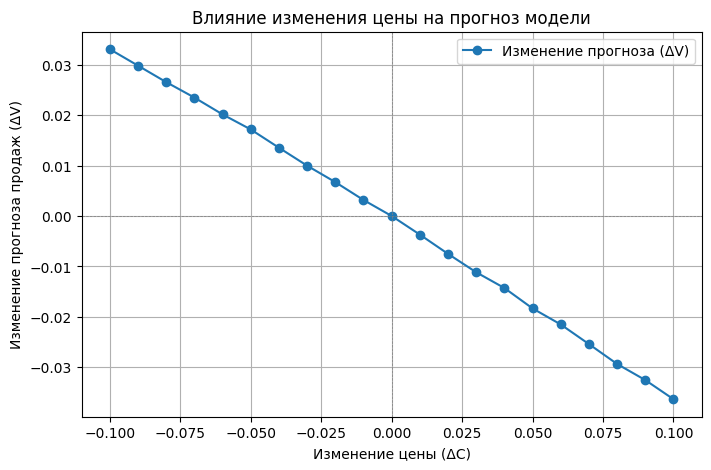

In [ ]:
V_pred_0 = final_model.predict(X_test)
results = []


for alpha in np.arange(-0.1, 0.101, 0.01):
    # Модифицируем target_cost
    X_test_modified = X_test.copy()
    X_test_modified['target_cost'] = X_test['target_cost'] * (1 + alpha)
    
    # Прогнозируем с изменённым target_cost
    V_pred_modified = final_model.predict(X_test_modified)
    
    # Рассчитываем ΔV и ΔC
    delta_V = (V_pred_modified - V_pred_0) / V_pred_0
    delta_C = alpha  # поскольку C_modified = C_0 * (1 + alpha)
    
    # Сохраняем результаты
    results.append({
        'alpha': alpha,
        'delta_C': delta_C,
        'delta_V': delta_V  # все значения (для графика)
    })

# 3. Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

# График: только средние значения delta_V
plt.figure(figsize=(8, 5))
plt.plot(
    results_df['delta_C'],
    results_df['delta_V_mean'],
    'o-',  # точки + линия
    label='Изменение прогноза (ΔV)'
)

# Разметка
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Изменение цены (ΔC)')
plt.ylabel('Изменение прогноза продаж (ΔV)')
plt.title('Влияние изменения цены на прогноз модели')
plt.legend()
plt.grid(True)
plt.show()